## Lesson 20:
### Exercise 1: Can a computer learn if we're going to detect gravitational waves?

In [10]:
import numpy as np
import h5py
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd

%config InlineBackend.figure_format='retina'

c = sns.color_palette('Paired', 7)
plt.rcParams['figure.figsize'] = (8, 5)

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=False)

#------------------- Function to read the data -------------------
def Dataframe(namefile):                                        #-
    df = pd.read_csv(namefile, sep=',', skipinitialspace=True)  #-
    return df                                                   #-
#-----------------------------------------------------------------

Our goal is to classify the sources in the following dataset according to their **detectability**. The `det` feature is containing the labels for each source.
- **0 = not detectable**
- **1 = detectable**

We want to train a classifier in order to separate sources that are detectables from those that aren't.

Let's load the dataset first:

In [11]:
import pickle

In [12]:
#Execute this the first time. It generates a dataframe from the h5 file and save it in a pickle file you can load later
"""
data_df = pd.read_hdf('sample_2e7_design_precessing_higherordermodes_3detectors.h5')

pickle_path = "data.pickle"  # Path to save the pickle file
data_df.to_pickle(pickle_path)
"""

'\ndata_df = pd.read_hdf(\'sample_2e7_design_precessing_higherordermodes_3detectors.h5\')\n\npickle_path = "data.pickle"  # Path to save the pickle file\ndata_df.to_pickle(pickle_path)\n'

In [13]:
with open('data.pickle', 'rb') as f:
    df = pickle.load(f)

In [14]:
display(df.head())

chi1x     chi1y     chi1z     chi2x     chi2y     chi2z       dec  det  \
0 -0.307201  0.276165 -0.430760 -0.161114 -0.092334 -0.414647 -0.329671    0   
1 -0.734712 -0.498493 -0.298162  0.057532 -0.844992  0.014708  0.526740    0   
2 -0.057831 -0.703796 -0.354512 -0.215538  0.016323  0.130543  0.315799    0   
3  0.015260 -0.202467 -0.492768 -0.237033 -0.365363 -0.876192  0.432105    0   
4 -0.016731  0.007848  0.005007  0.147519  0.231879  0.086716 -0.458711    1   

       iota        mtot       psi         q        ra        snr         z  
0  1.809310  906.803562  1.286031  0.624780 -3.116784   0.822509  2.139659  
1  0.820820   59.102112  0.934308  0.986650  1.360291   1.093237  2.438707  
2  2.008206   44.602750  1.535520  0.286199  0.079973   1.305398  1.869461  
3  2.018398  534.378032  3.064086  0.538882 -1.780558   9.112974  0.428061  
4  2.037363  573.821705  0.752211  0.846310  2.789289  17.525534  0.772609

For debugging purposes let's define a downsampled dataset `df_small` with the first 5000 data points

In [15]:
df_small = df.iloc[:100000]
df_small

chi1x     chi1y     chi1z     chi2x     chi2y     chi2z       dec  \
0     -0.307201  0.276165 -0.430760 -0.161114 -0.092334 -0.414647 -0.329671   
1     -0.734712 -0.498493 -0.298162  0.057532 -0.844992  0.014708  0.526740   
2     -0.057831 -0.703796 -0.354512 -0.215538  0.016323  0.130543  0.315799   
3      0.015260 -0.202467 -0.492768 -0.237033 -0.365363 -0.876192  0.432105   
4     -0.016731  0.007848  0.005007  0.147519  0.231879  0.086716 -0.458711   
...         ...       ...       ...       ...       ...       ...       ...   
99995 -0.710484  0.203788 -0.030539 -0.194861  0.014570 -0.054834 -0.239913   
99996  0.804222  0.086352  0.550408  0.181968  0.824057  0.412858  0.195437   
99997  0.652722 -0.022264  0.132145  0.272847  0.381442  0.773596 -0.584279   
99998 -0.134977  0.016409 -0.207572 -0.100090  0.117877  0.054799  0.754165   
99999 -0.053634 -0.633171  0.004736  0.102390 -0.126433  0.217027 -0.121681   

       det      iota        mtot       psi         q        ra        snr  \
0        0  1.809310  906.803562  1.286031  0.624780 -3.116784   0.822509   
1        0  0.820820   59.102112  0.934308  0.986650  1.360291   1.093237   
2        0  2.008206   44.602750  1.535520  0.286199  0.079973   1.305398   
3        0  2.018398  534.378032  3.064086  0.538882 -1.780558   9.112974   
4        1  2.037363  573.821705  0.752211  0.846310  2.789289  17.525534   
...    ...       ...         ...       ...       ...       ...        ...   
99995    0  1.905192  326.220322  1.473113  0.802986  1.273264   1.669939   
99996    0  1.920145  403.949547  0.184597  0.386258 -1.279446   6.605718   
99997    1  2.637491  884.399749  1.601521  0.722733  0.444194  14.355243   
99998    1  1.147342  949.832616  0.060168  0.459489 -0.415330  12.521137   
99999    1  2.540554  737.411951  0.139552  0.826515  1.233508  16.968431   

              z  
0      2.139659  
1      2.438707  
2      1.869461  
3      0.428061  
4      0.772609  
...         ...  
99995  1.901201  
99996  1.491419  
99997  0.735589  
99998  0.394833  
99999  0.416194  

[100000 rows x 15 columns]

Let's define a **training** and a **test** sub-dataframe in order to validate the performance of our classifier on unseen data (classification error).

In [16]:
train, test = train_test_split(df_small, test_size = 0.2, random_state=42)

We choose to use a **Random Forest Classifier**. This is based on multiple decision trees. For each of those, at each step, the dimension in the parameter space in which to "cut" is selected randomly. Each decision tree votes at the end for the final classification. Our dataset is highly multi-dimensional, thus the choice of this particular classifier.

**RandomForestClassifier** is implemented in *scikit-learn* and it gives access to the *importances* (weights) of the features. This is useful for determining the most relevant features of the dataset, that is the dimensions in which the sources can be most easily classified.

Notice that we *whiten* the data first, so that the classifier is not biased.

**NB**: We fit the classifier on a dataset in which `det` and `snr` columns are removed. The **det** column is the target column, while the **snr** directly defines the target (detectability). If left in the training dataset, the **snr** column would obviously be the most relevant feature. See the next plot.

[]

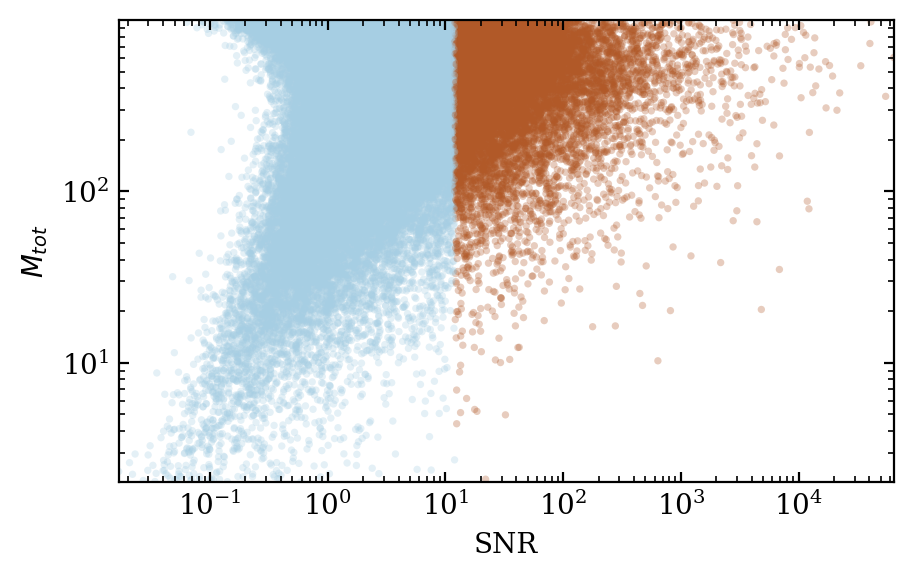

In [17]:
fig = plt.figure(figsize=(5,3))
plt.scatter(df_small['snr'], df_small['mtot'], c=df_small['det'], edgecolors='none', alpha=0.3, s=7, cmap='Paired')
plt.xlabel('SNR')
plt.ylabel('$M_{tot}$')
plt.loglog()

---

### Random Forest Classification

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

#--------------------------------------------------------------------
# Prepare the data

X_train = train.drop(['det', 'snr'], axis=1).values
y_train = train['det'].values

X_test = test.drop(['det', 'snr'], axis=1).values
y_test = test['det'].values

scaler = StandardScaler()
scaler.fit(X_train)
X_scaled_train = scaler.transform(X_train)

scaler.fit(X_test)
X_scaled_test = scaler.transform(X_test)

#---------------------------------------------------------------------
# Fit the Random Forest classifier and predict
max_depth = 10

ranfor = RandomForestClassifier(n_estimators=10, max_depth=max_depth)
ranfor.fit(X_scaled_train, y_train)

y_pred = ranfor.predict(X_scaled_test)
rfc_probs = ranfor.predict_proba(X_scaled_test)

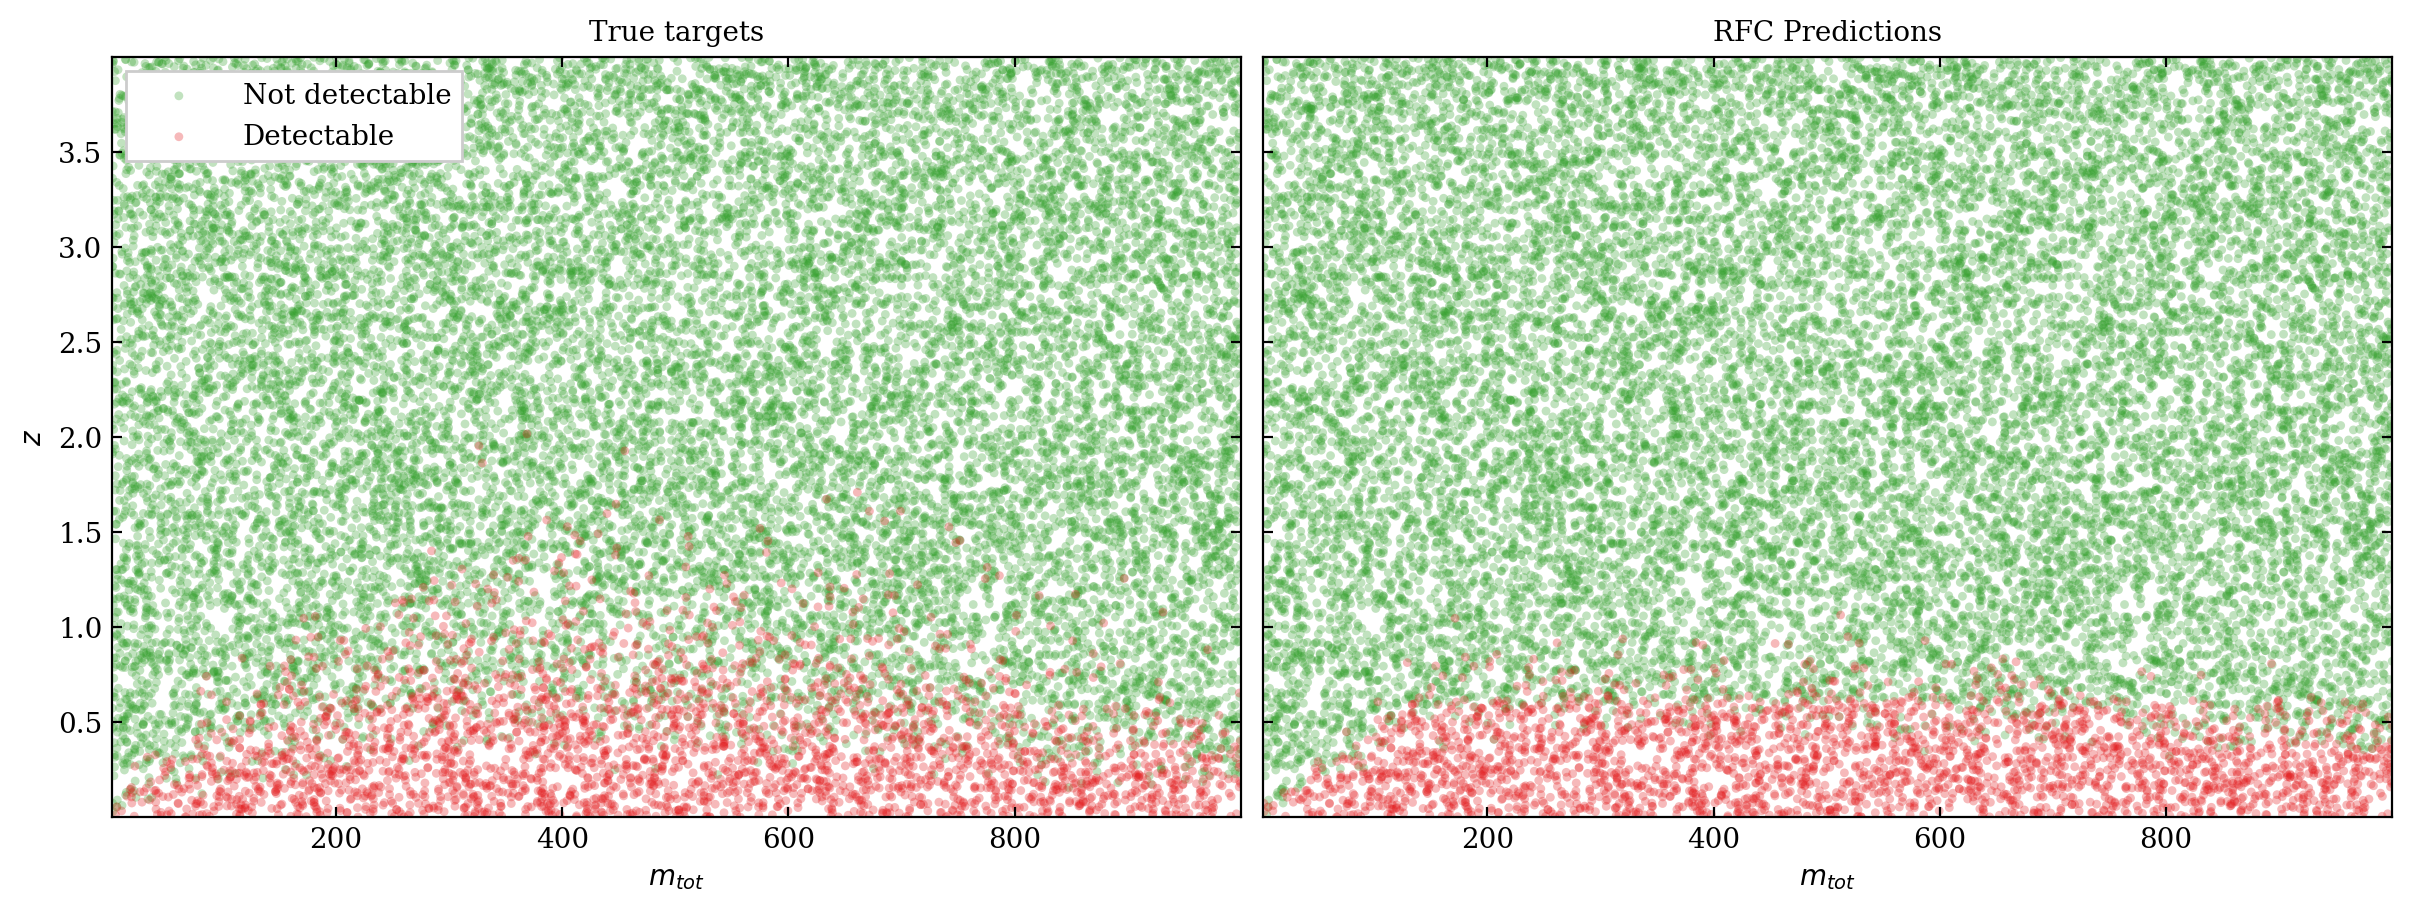

In [19]:
# Outcome
fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(bottom=0., top=0.95, hspace=0.0,
                    left=0., right=0.95, wspace=0.02)


ax = fig.add_subplot(121)
ax.xaxis.set_major_locator(plt.MultipleLocator(200))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

ax.set_title('True targets')
ax.set_xlabel(r'$m_{tot}$')
ax.set_ylabel(r'$z$')

ax.scatter(test['mtot'][y_test == 0], test['z'][y_test == 0], color=c[3], s=10, 
           edgecolors='none', alpha=0.3, label='Not detectable')

ax.scatter(test['mtot'][y_test == 1], test['z'][y_test == 1], color=c[5], s=10, 
           edgecolors='none', alpha=0.3, label='Detectable')
ax.legend(loc='upper left', framealpha=1, fancybox=False)

ax = fig.add_subplot(122)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.set_title('RFC Predictions')
ax.set_xlabel(r'$m_{tot}$')

ax.scatter(test['mtot'][y_pred == 0], test['z'][y_pred == 0], color=c[3], s=10, 
           edgecolors='none', alpha=0.3, label='Not detectable')

ax.scatter(test['mtot'][y_pred == 1], test['z'][y_pred == 1], color=c[5], s=10, 
           edgecolors='none', alpha=0.3, label='Detectable')


plt.show()

Now we can see which features are the most relevant:

In [20]:
column_names = df_small.drop(['det', 'snr'], axis=1).columns.tolist()

dict(zip(column_names, ranfor.feature_importances_))

{'chi1x': 0.0038802561481441427,
 'chi1y': 0.004731146412146603,
 'chi1z': 0.012232003969789396,
 'chi2x': 0.003929052893981929,
 'chi2y': 0.003951381887123543,
 'chi2z': 0.004773401891231194,
 'dec': 0.005349138197358115,
 'iota': 0.025965119931847885,
 'mtot': 0.04044273341945377,
 'psi': 0.004571547967046582,
 'q': 0.014491666961407365,
 'ra': 0.005969541910297056,
 'z': 0.8697130084101724}

The most relevant features are the *redshift* `z` (83% importance) and the *total mass* `mtot` (4% importance).

Now let's evaluate the performance of the classifier on the **test set**.

In [21]:
from sklearn.metrics import accuracy_score
from astroML.utils import completeness_contamination

print("The accuracy of the Random Forest Classifier is", accuracy_score(y_test, y_pred)*100, '%')

completeness, contamination = completeness_contamination(y_pred, y_test)

print("Completeness and contamination are:\n\t", completeness*100, "%\n\t", contamination*100, '%')

The accuracy of the Random Forest Classifier is 95.58 %
Completeness and contamination are:
	 81.32823365785814 %
	 12.918838421444528 %


In [22]:
from sklearn.metrics import roc_curve

positive_prob = rfc_probs[:,1] # 1: Detectable sources
fpr, tpr, thresholds = roc_curve(y_test, positive_prob)

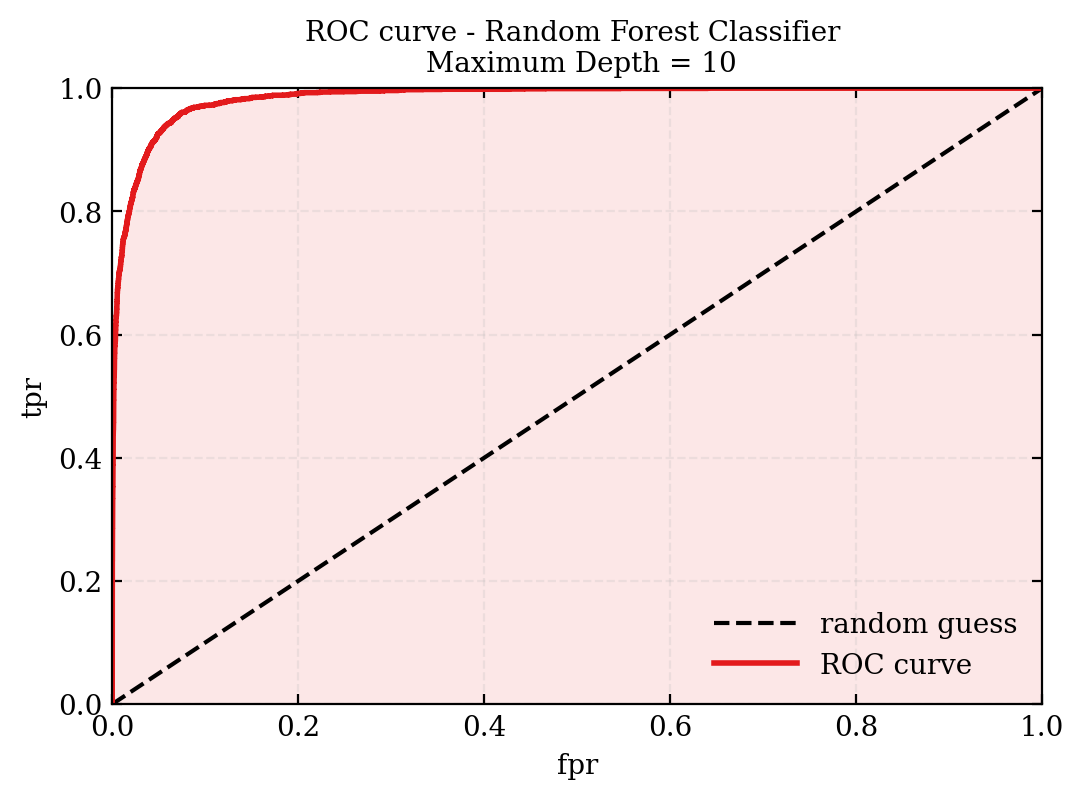

In [23]:
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.plot([0,1], [0,1], '--k', label='random guess')

ax.plot(fpr, tpr, ls='-', lw=2., c=c[5], label=r'ROC curve')

ax.fill_between(fpr, tpr, color=c[5], alpha=0.1)
    
ax.set_xlabel('fpr');
ax.set_ylabel('tpr');
ax.legend(loc='lower right', frameon=False);
ax.set_title(f'ROC curve - Random Forest Classifier \n Maximum Depth = %i'%max_depth);

ax.grid(True, ls='--', alpha=0.2)

Notice that changing the value of `max_depth` in the definition of the classifier is changing the final accuracy score. We can cross validate it by using *GridSearchCV*.

### `max_depth` cross validation
- With *GridSearchCV* it takes about 1 minute on my laptop.

In [24]:
from sklearn.model_selection import GridSearchCV

depth_range = np.linspace(1 ,1000, 11, dtype=int)

K = 5 # 5-fold cross validation

grid = GridSearchCV(RandomForestClassifier(), {'max_depth': depth_range}, cv = K, n_jobs=-1) 
grid.fit(X_scaled_train, y_train)
depth_opt = grid.best_params_['max_depth']

In [25]:
print("The optimal maximum depth is", depth_opt)

The optimal maximum depth is 400


In [26]:
ranfor = RandomForestClassifier(n_estimators=10, max_depth=depth_opt)
ranfor.fit(X_scaled_train, y_train)

y_pred = ranfor.predict(X_scaled_test)

print("The accuracy of the Random Forest Classifier, with optimal maximum depth, is", 
      accuracy_score(y_test, y_pred)*100, '%')

completeness, contamination = completeness_contamination(y_pred, y_test)

print("Completeness and contamination are:\n\t", completeness*100, "%\n\t", contamination*100, '%')

The accuracy of the Random Forest Classifier, with optimal maximum depth, is 96.0 %
Completeness and contamination are:
	 81.32823365785814 %
	 10.107609531129901 %


---

### PCA dimensionality reduction attempt before classification

[]

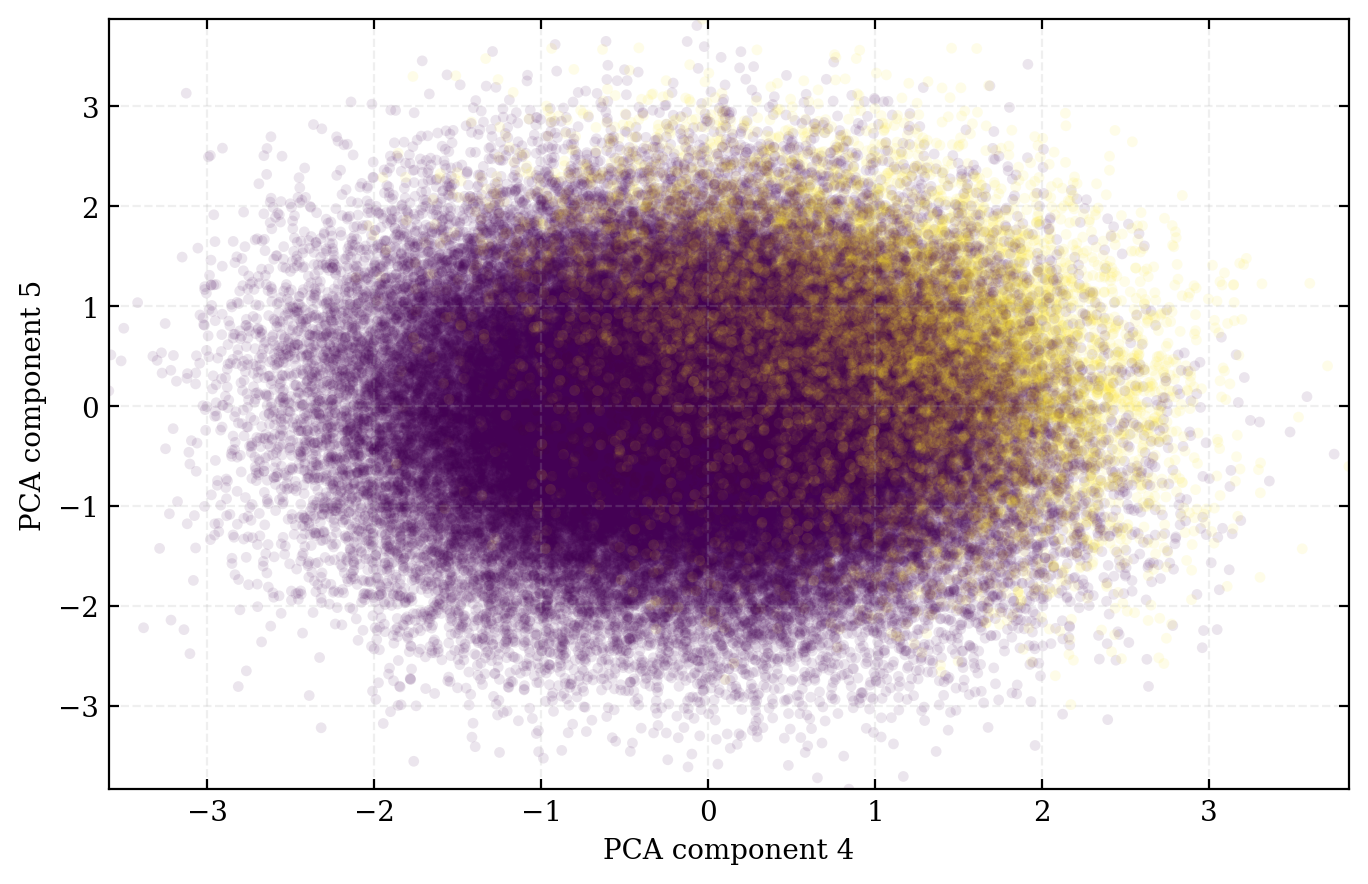

In [85]:
df_X = df_small.drop(['det', 'snr'], axis=1)
df_y = df_small['det']

# We first whiten the data
scaler = StandardScaler()
scaler.fit(df_X)
X_scaled = scaler.transform(df_X)

# Now we apply the PCA algorithm.
from sklearn.decomposition import PCA

pca = PCA(n_components=6) 
pca.fit(X_scaled)

X_red = pca.transform(X_scaled)

plt.scatter(X_red[:,3], X_red[:,4], c=df_y[:], edgecolors='none', s=15, alpha=0.1)
plt.grid(True, ls='--', alpha=0.2)
plt.xlabel("PCA component 4")
plt.ylabel("PCA component 5")
plt.plot()

It's a mess. Clearly, applying PCA on the whole dataset is not making the separation more evident. 

If we run PCA with *n_components = 6*, the $4^{th}$ and the $5^{th}$ components are showing some separation.

Let's try to apply the **Random Forest Classifier** anyway, on the reduced dataset.

In [86]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_red, df_y, test_size = 0.2, random_state=42)

In [87]:
ranfor = RandomForestClassifier(n_estimators=10, max_depth=depth_opt)
ranfor.fit(X_train_p, y_train_p)

y_pred_p = ranfor.predict(X_test_p)
rfc_probs_p = ranfor.predict_proba(X_test_p)

In [88]:
print("The accuracy of the Random Forest Classifier is", accuracy_score(y_test_p, y_pred_p)*100, '%')

completeness, contamination = completeness_contamination(y_pred_p, y_test_p)

print("Completeness and contamination are:\n\t", completeness*100, "%\n\t", contamination*100, '%')

The accuracy of the Random Forest Classifier is 85.88 %
Completeness and contamination are:
	 21.66203059805285 %
	 47.82244556113903 %


Not a great classification. $21\%$ completeness and $46\%$ contamination, clearly suggest to give up PCA.